In [1]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.base import clone
from catboost import CatBoostRegressor
import plotly.graph_objects as go
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import matplotlib
import numpy as np
import warnings
import optuna
import json

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
SEED = 42
N_FOLDS = 5
N_REPEATS = 3
N_OPTUNA_TRIALS = 100

DATASET_PATH = '/kaggle/input/kode24-lnnstall/2025.csv'

In [3]:
dataset = pd.read_csv(DATASET_PATH)
dataset = dataset.dropna(subset=['lønn'])
dataset = dataset[dataset["års utdanning"] < 20].reset_index(drop=True)

In [4]:
dataset

,kjønn,års utdanning,års erfaring,arbeidssted,jobbtype,fag,lønn,inkludert bonus?,inkludert provisjon?
0,mann,5,10,Agder,"in-house, privat sektor",AI / maskinlæring,920000,False,False
1,mann,5,27,Agder,"in-house, privat sektor",AI / maskinlæring,1300000,True,True
2,mann,7,13,Akershus,frilans / selvstendig næringsdrivende,AI / maskinlæring,1000000,False,False
3,kvinne,5,2,Oslo,"in-house, privat sektor",AI / maskinlæring,600000,False,False
4,kvinne,5,5,Oslo,konsulent,AI / maskinlæring,860000,True,False
...,...,...,...,...,...,...,...,...,...
1977,mann,3,10,Oslo,"in-house, privat sektor",UX / design,934000,False,False
1978,mann,0,18,Oslo,"in-house, privat sektor",UX / design,1600000,False,False
1979,mann,3,3,Oslo,konsulent,UX / design,830000,False,False
1980,mann,0,16,Trøndelag,konsulent,UX / design,820000,False,False


# Topp 10 best betalte

In [5]:
dataset.sort_values(by='lønn', ascending=False).head(10)

,kjønn,års utdanning,års erfaring,arbeidssted,jobbtype,fag,lønn,inkludert bonus?,inkludert provisjon?
1668,mann,0,17,Vestland,frilans / selvstendig næringsdrivende,fullstack,3830000,False,False
1868,mann,5,27,Oslo,"in-house, privat sektor",programvare,3400000,True,False
1001,mann,3,4,utlandet,"in-house, privat sektor",frontend,3000000,False,False
1796,mann,5,12,Oslo,"in-house, privat sektor",ledelse/administrativt,2800000,True,False
1363,mann,5,5,Oslo,"in-house, privat sektor",fullstack,2600000,False,False
691,mann,4,6,Vestland,frilans / selvstendig næringsdrivende,databaser,2550000,False,True
1795,mann,3,22,Oslo,"in-house, privat sektor",ledelse/administrativt,2505000,True,False
176,mann,3,20,Rogaland,frilans / selvstendig næringsdrivende,arkitektur,2500000,False,False
152,mann,9,15,Oslo,"in-house, privat sektor",arkitektur,2500000,True,False
1081,mann,0,30,Akershus,konsulent,fullstack,2400000,False,True


# Topp 10 dårlegast betalte

In [6]:
dataset.sort_values(by='lønn', ascending=False).tail(10)

,kjønn,års utdanning,års erfaring,arbeidssted,jobbtype,fag,lønn,inkludert bonus?,inkludert provisjon?
1639,mann,3,2,Vestfold,"in-house, privat sektor",fullstack,450000,False,False
1489,mann,0,3,Østfold,konsulent,fullstack,450000,False,False
1929,mann,5,2,Rogaland,"in-house, privat sektor",sikkerhet,450000,False,False
682,kvinne,3,10,Østfold,"in-house, privat sektor",databaser,450000,False,False
704,mann,0,6,Innlandet,konsulent,devops / drift,450000,False,False
827,kvinne,5,9,Innlandet,"in-house, privat sektor",frontend,450000,False,False
1182,mann,5,6,Oslo,frilans / selvstendig næringsdrivende,fullstack,400000,False,False
64,mann,0,13,Vestland,"in-house, privat sektor",annet,390000,False,False
1626,mann,2,0,utlandet,"in-house, privat sektor",fullstack,360000,True,False
828,mann,7,2,Innlandet,frilans / selvstendig næringsdrivende,frontend,300000,False,False


# Best betalte stillinger

In [7]:
avg_salaries_by_job_type = dataset.groupby('fag')['lønn'].mean().reset_index().sort_values(by='lønn', ascending=True)

fig = px.bar(
    avg_salaries_by_job_type,
    y='fag', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'fag': 'Fag', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Fag',
    width=800,
    height=400,
    font=dict(size=10)
)

for i, row in avg_salaries_by_job_type.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['fag'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()


In [8]:
avg_salary_by_fag = dataset.groupby('fag')['lønn'].mean().reset_index()
sorted_fag = avg_salary_by_fag.sort_values(by='lønn', ascending=True)['fag']
dataset_sorted = dataset.set_index('fag').loc[sorted_fag].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='fag',    
    width=800, 
    height=400
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Fag',      
    xaxis_range=[0, 2_400_000], 
    font=dict(size=10)
)

fig.show()

# Kvar lønnar det seg å jobbe?

In [9]:
avg_salaries_by_city = dataset.groupby('arbeidssted')['lønn'].mean().reset_index().sort_values(by='lønn', ascending=True)

fig = px.bar(
    avg_salaries_by_city,
    y='arbeidssted', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'arbeidssted': 'Fylke', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Fylke',
    width=800,
    height=400,
    font=dict(size=10)
)

for i, row in avg_salaries_by_city.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['arbeidssted'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()


In [10]:
avg_salary_by_city = dataset.groupby('arbeidssted')['lønn'].mean().reset_index()
sorted_city = avg_salary_by_city.sort_values(by='lønn', ascending=True)['arbeidssted']
dataset_sorted = dataset.set_index('arbeidssted').loc[sorted_city].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='arbeidssted',    
    width=800, 
    height=400, 
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Fylke',      
    xaxis_range=[0, 2_400_000], 
    font=dict(size=10)
)

fig.show()

# Erfaring og utdanning

In [11]:
cleaned_data = dataset.dropna(subset=['års erfaring', 'lønn'])
cleaned_data['lønn'] = cleaned_data['lønn'].astype(float)
avg_salary_by_experience = cleaned_data.groupby('års erfaring')['lønn'].mean().reset_index()
lowest_point = avg_salary_by_experience.loc[avg_salary_by_experience['lønn'].idxmin()]
highest_point = avg_salary_by_experience.loc[avg_salary_by_experience['lønn'].idxmax()]

fig = px.line(
    avg_salary_by_experience,
    x='års erfaring',
    y='lønn',
    labels={'års erfaring': 'Erfaring', 'lønn': 'Gjennomsnittsløn (NOK)'}
)


fig.add_trace(
    go.Scatter(
        x=[lowest_point['års erfaring']],
        y=[lowest_point['lønn']],
        mode='markers+text',
        marker=dict(color='red', size=10),
        name='Lågast løn',
        text=[f'Lågast løn: {lowest_point["lønn"]:,.0f} NOK, Erfaring: {int(lowest_point["års erfaring"])} år'],
        textfont=dict(size=10, color='red'),
        textposition='bottom right'
    )
)
fig.add_trace(
    go.Scatter(
        x=[highest_point['års erfaring']],
        y=[highest_point['lønn']],
        mode='markers+text',
        marker=dict(color='green', size=10),
        name='Høgest løn',
        text=[f'Høgast løn: {highest_point["lønn"]:,.0f} NOK, Erfaring: {int(highest_point["års erfaring"])} år'],
        textfont=dict(size=10, color='green'),
        textposition='top center'
    )
)

fig.update_layout(
    xaxis_title='Erfaring',
    yaxis_title='Gjennomsnittsløn (NOK)',
    width=800,
    height=400,
    font=dict(size=10)
)

fig.update_layout(showlegend=False)
fig.show()

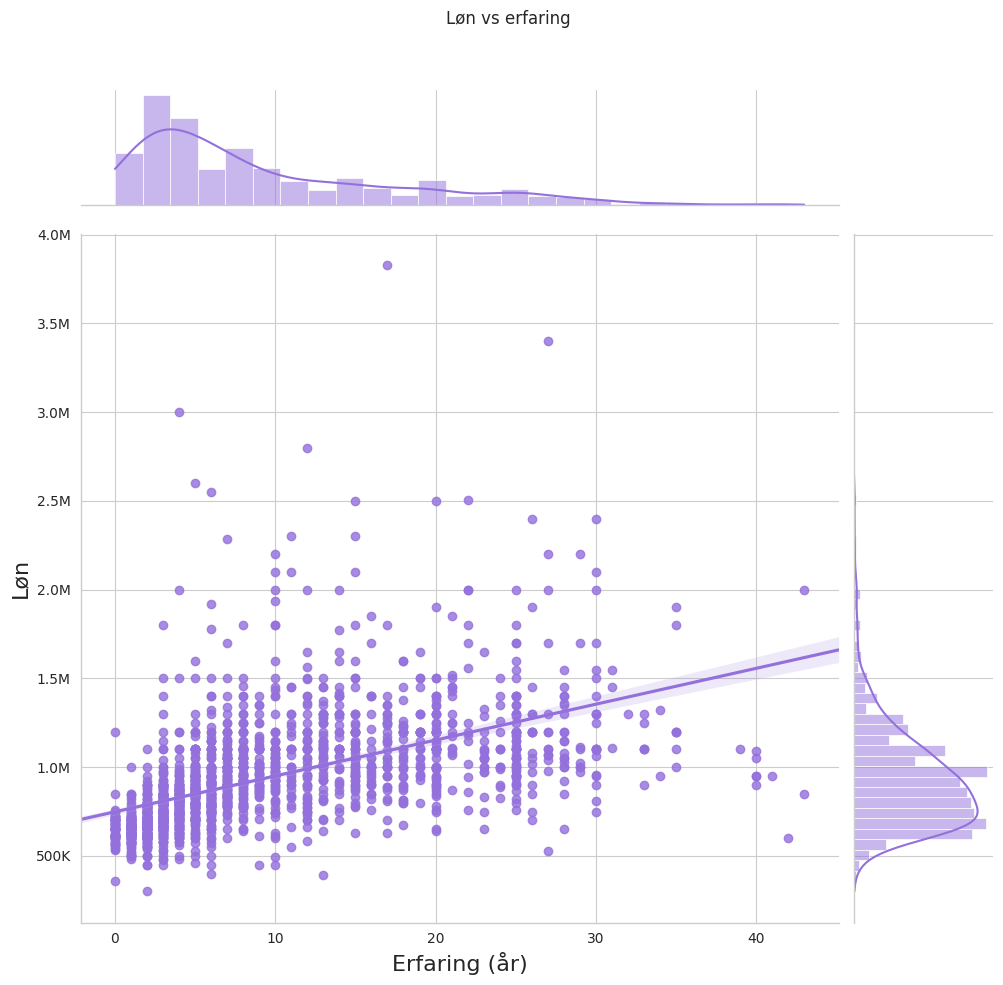

In [12]:
def currency_format(x, pos):
    'The two args are the value and tick position'
    if x >= 1e6:
        s = '{:.1f}M'.format(x*1e-6)
    else:
        s = '{:.0f}K'.format(x*1e-3)
    return s

sns.set_style('whitegrid')
g = sns.jointplot(
    x='års erfaring',
    y='lønn',
    data=dataset,
    kind='reg',
    truncate=False,
    color='#9370DB',
    height=10,
)
g.set_axis_labels('Erfaring (år)', 'Løn', fontsize=16)
g.fig.suptitle('Løn vs erfaring')
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

g.ax_joint.yaxis.set_major_formatter(mtick.FuncFormatter(currency_format))

In [13]:
cleaned_data = dataset.dropna(subset=['års utdanning', 'lønn'])
cleaned_data['lønn'] = cleaned_data['lønn'].astype(float)
avg_salary_by_edu = cleaned_data.groupby('års utdanning')['lønn'].mean().reset_index()
lowest_point = avg_salary_by_edu.loc[avg_salary_by_edu['lønn'].idxmin()]
highest_point = avg_salary_by_edu.loc[avg_salary_by_edu['lønn'].idxmax()]

fig = px.line(
    avg_salary_by_edu,
    x='års utdanning',
    y='lønn',
    labels={'års utdanning': 'Utdanning', 'lønn': 'Gjennomsnittslønn (NOK)'}
)


fig.add_trace(
    go.Scatter(
        x=[lowest_point['års utdanning']],
        y=[lowest_point['lønn']],
        mode='markers+text',
        marker=dict(color='red', size=10),
        name='Lågast løn',
        text=[f'Lågast løn: {lowest_point["lønn"]:,.0f} NOK, Utdanning: {int(lowest_point["års utdanning"])} år'],
        textfont=dict(size=10, color='red'),
        textposition='bottom right'
    )
)
fig.add_trace(
    go.Scatter(
        x=[highest_point['års utdanning']],
        y=[highest_point['lønn']],
        mode='markers+text',
        marker=dict(color='green', size=10),
        name='Høgest løn',
        text=[f'Høgast løn: {highest_point["lønn"]:,.0f} NOK, Utdanning: {int(highest_point["års utdanning"])} år'],
        textfont=dict(size=10, color='green'),
        textposition='top left'
    )
)

fig.update_layout(
    xaxis_title='års utdanning',
    yaxis_title='Gjennomsnittsløn (NOK)',
    width=800,
    height=400,
    font=dict(size=10)
)

fig.update_layout(showlegend=False)
fig.show()

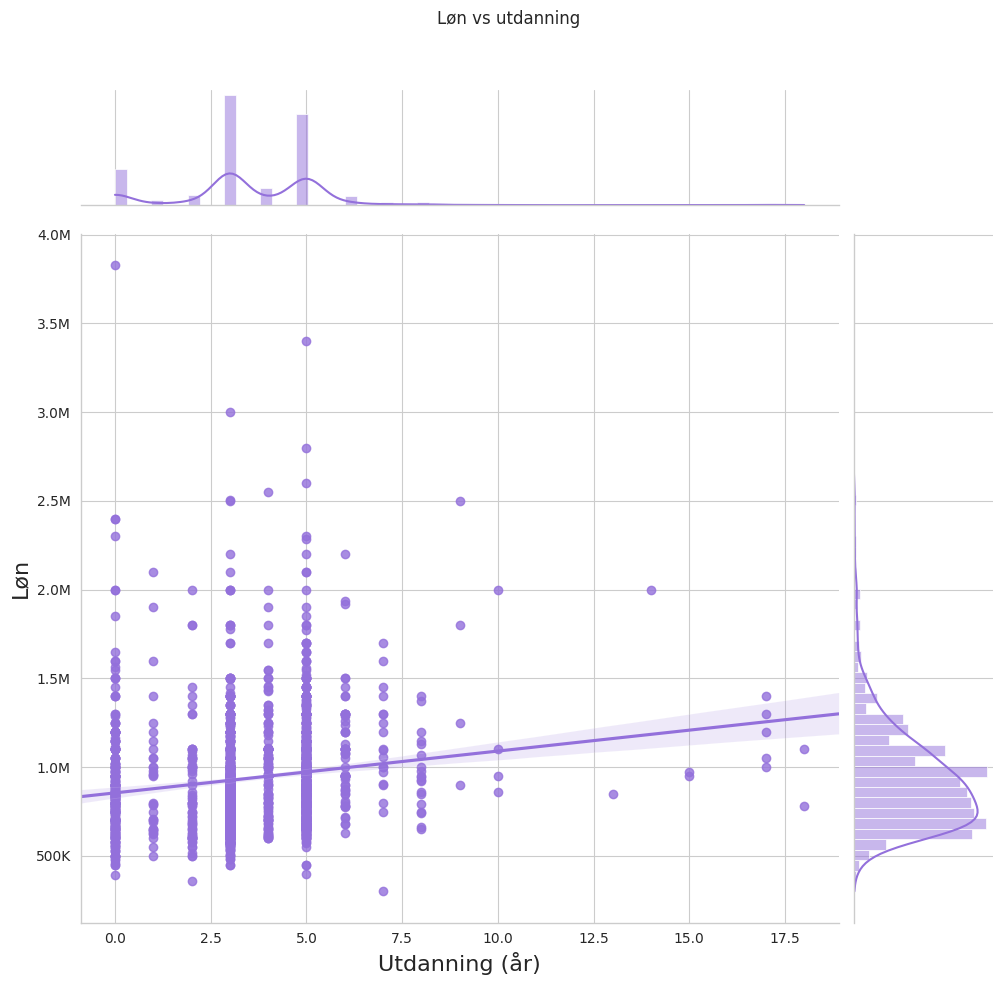

In [14]:
sns.set_style('whitegrid')
g = sns.jointplot(
    x='års utdanning',
    y='lønn',
    data=dataset,
    kind='reg',
    truncate=False,
    color='#9370DB',
    height=10
)
g.set_axis_labels('Utdanning (år)', 'Løn', fontsize=16)
g.fig.suptitle('Løn vs utdanning')
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

g.ax_joint.yaxis.set_major_formatter(mtick.FuncFormatter(currency_format))

# Privat, offentleg, konsulent, eller frilans

In [15]:
avg_salaries_by_employer = dataset.groupby('jobbtype')['lønn'].mean().reset_index().sort_values(by='lønn', ascending=True)

fig = px.bar(
    avg_salaries_by_employer,
    y='jobbtype', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'jobbtype': 'Jobb', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Jobb',
    width=800,
    height=300,
    font=dict(size=10)    
)

for i, row in avg_salaries_by_employer.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['jobbtype'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()

In [16]:
avg_salaries_by_employer = dataset.groupby('jobbtype')['lønn'].mean().reset_index()
sorted_city = avg_salaries_by_employer.sort_values(by='lønn', ascending=True)['jobbtype']
dataset_sorted = dataset.set_index('jobbtype').loc[sorted_city].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='jobbtype',    
    width=800, 
    height=300, 
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Jobb',  
    font=dict(size=10)    
)

fig.show()

# Lønsforskjellar

In [17]:
avg_salaries_by_gender = dataset.groupby('kjønn')['lønn'].mean().reset_index().sort_values(by='lønn', ascending=True)

fig = px.bar(
    avg_salaries_by_gender,
    y='kjønn', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'kjønn': 'Kjønn', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Kjønn',
    width=800,
    height=300,
    font=dict(size=10)    
)

for i, row in avg_salaries_by_gender.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['kjønn'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()

In [18]:
avg_salaries_by_gender = dataset.groupby('kjønn')['lønn'].mean().reset_index()
sorted_city = avg_salaries_by_gender.sort_values(by='lønn', ascending=True)['kjønn']
dataset_sorted = dataset.set_index('kjønn').loc[sorted_city].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='kjønn',    
    width=800, 
    height=300, 
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Kjønn',  
    font=dict(size=10)    
)

fig.show()

# Korrelasjon mellom lønn og andre variablar

In [19]:
for col in dataset.columns:
    if dataset[col].dtype == 'object':
        dataset[col] = dataset[col].astype('category')
        dataset[col] = dataset[col].cat.codes

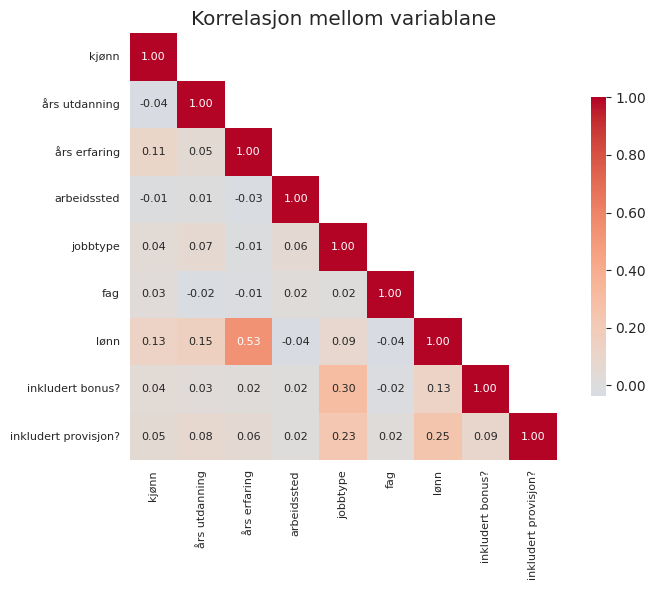

In [20]:
corr_train = dataset.corr(numeric_only=True)
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)

sns.set_style('white')
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=ax
)
ax.set_title('Korrelasjon mellom variablane')
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

# Prediksjon av løn

In [21]:
dataset = pd.read_csv(DATASET_PATH)
dataset = dataset[dataset["års utdanning"] < 20].reset_index(drop=True)

In [22]:
dataset

,kjønn,års utdanning,års erfaring,arbeidssted,jobbtype,fag,lønn,inkludert bonus?,inkludert provisjon?
0,mann,5,10,Agder,"in-house, privat sektor",AI / maskinlæring,920000,False,False
1,mann,5,27,Agder,"in-house, privat sektor",AI / maskinlæring,1300000,True,True
2,mann,7,13,Akershus,frilans / selvstendig næringsdrivende,AI / maskinlæring,1000000,False,False
3,kvinne,5,2,Oslo,"in-house, privat sektor",AI / maskinlæring,600000,False,False
4,kvinne,5,5,Oslo,konsulent,AI / maskinlæring,860000,True,False
...,...,...,...,...,...,...,...,...,...
1977,mann,3,10,Oslo,"in-house, privat sektor",UX / design,934000,False,False
1978,mann,0,18,Oslo,"in-house, privat sektor",UX / design,1600000,False,False
1979,mann,3,3,Oslo,konsulent,UX / design,830000,False,False
1980,mann,0,16,Trøndelag,konsulent,UX / design,820000,False,False


In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   kjønn                 1982 non-null   object
 1   års utdanning         1982 non-null   int64 
 2   års erfaring          1982 non-null   int64 
 3   arbeidssted           1982 non-null   object
 4   jobbtype              1982 non-null   object
 5   fag                   1982 non-null   object
 6   lønn                  1982 non-null   int64 
 7   inkludert bonus?      1982 non-null   bool  
 8   inkludert provisjon?  1982 non-null   bool  
dtypes: bool(2), int64(3), object(4)
memory usage: 112.4+ KB


In [24]:
dataset.describe()

,års utdanning,års erfaring,lønn
count,1982.000000,1982.000000,1.982000e+03
mean,3.530272,9.386478,9.381552e+05
std,2.026787,8.262233,3.122081e+05
min,0.000000,0.000000,3.000000e+05
25%,3.000000,3.000000,7.200000e+05
50%,3.000000,6.000000,8.800000e+05
75%,5.000000,14.000000,1.090000e+06
max,18.000000,43.000000,3.830000e+06


## Data prosessering

In [25]:
def get_data():
    train = pd.read_csv(DATASET_PATH)
    test = {
        'kjønn': ['mann'],
        'års utdanning': [5],
        'års erfaring': [3],
        'arbeidssted': ['Vestland'],
        'jobbtype': ['in-house, privat sektor'],
        'fag': ['backend'],
        'inkludert bonus?': [True],
        'inkludert provisjon?': [False],
    }

    test = pd.DataFrame(test)

    cat_cols = train.select_dtypes('object').columns.tolist()
    for cat_col in cat_cols:
        train[cat_col] = train[cat_col].astype('category')
        test[cat_col] = test[cat_col].astype('category')
        
    X = train.drop(columns='lønn')
    y = train['lønn']
    X_test = test
    
    return X, y, X_test

In [26]:
X, y, X_test = get_data()
cat_cols = X.select_dtypes('category').columns.tolist()

## Trening av CatBoost

In [27]:
class Trainer:
    def __init__(self, model, X, y, n_splits=N_FOLDS, n_repeats=N_REPEATS):
        self.model = model
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self, tune=False):
        scores = []        
        skf = KFold(n_splits=self.n_splits, shuffle=True, random_state=SEED)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(self.X, self.y)):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = mean_absolute_error(y_val, y_pred)
            scores.append(score)
            
            if not tune:
                print(f'--- Fold {fold_idx+1} - MAE Score: {score:.6f}')
            
        if not tune:
            print(f'\n------ Mean MAE Score: {np.mean(scores):.6f}')
            
        return scores
        
    def predict(self, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(self.X, self.y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [28]:
model = CatBoostRegressor(verbose=False, cat_features=cat_cols)
trainer = Trainer(model, X, y)
scores = trainer.fit()

--- Fold 1 - MAE Score: 140836.008574
--- Fold 2 - MAE Score: 138652.799278
--- Fold 3 - MAE Score: 137198.733542
--- Fold 4 - MAE Score: 110880.282848
--- Fold 5 - MAE Score: 145276.957209

------ Mean MAE Score: 134568.956290


## Hyperparameter optimalisering

In [29]:
def objective(trial):
    params = {
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 100),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'iterations': trial.suggest_int('iterations', 100, 1000),  
        'random_state': SEED,
        'verbose': False
    }
    
    model = CatBoostRegressor(**params, cat_features=cat_cols)
    trainer = Trainer(model, X, y)
    scores = trainer.fit(tune=True)
    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_OPTUNA_TRIALS, n_jobs=-1)

[I 2025-10-08 08:28:15,624] A new study created in memory with name: no-name-1ac38cbd-53e8-4d1a-aa49-b7facf6c5335
[I 2025-10-08 08:28:23,160] Trial 2 finished with value: 178152.52127669044 and parameters: {'random_strength': 0.7336403269368073, 'depth': 7, 'learning_rate': 0.004975944267033889, 'l2_leaf_reg': 3.8022802890932264, 'bagging_temperature': 71.84023597029203, 'border_count': 20, 'iterations': 111}. Best is trial 2 with value: 178152.52127669044.
[I 2025-10-08 08:28:51,032] Trial 0 finished with value: 149331.8892973184 and parameters: {'random_strength': 0.5824071698888127, 'depth': 4, 'learning_rate': 0.08002749456473378, 'l2_leaf_reg': 9.809181922144498, 'bagging_temperature': 77.6043411579465, 'border_count': 1, 'iterations': 946}. Best is trial 0 with value: 149331.8892973184.
[I 2025-10-08 08:28:59,131] Trial 1 finished with value: 133178.86584807368 and parameters: {'random_strength': 0.4638327518454498, 'depth': 8, 'learning_rate': 0.034674766496312584, 'l2_leaf_reg'

## Prediksjon med nye hyperparameterar

In [30]:
params = {
    **study.best_params,
    'random_state': SEED,
    'verbose': False
}
print(json.dumps(params, indent=4))

{
    "random_strength": 0.8178247646422431,
    "depth": 7,
    "learning_rate": 0.035212582526806306,
    "l2_leaf_reg": 7.842304166961149,
    "bagging_temperature": 70.8377725805058,
    "border_count": 19,
    "iterations": 480,
    "random_state": 42,
    "verbose": false
}


In [31]:
model = CatBoostRegressor(cat_features=cat_cols, **params)
trainer = Trainer(model, X, y)
scores = trainer.fit()

--- Fold 1 - MAE Score: 136264.689487
--- Fold 2 - MAE Score: 138220.773448
--- Fold 3 - MAE Score: 133206.737660
--- Fold 4 - MAE Score: 108827.269115
--- Fold 5 - MAE Score: 145615.561738

------ Mean MAE Score: 132427.006290


In [32]:
preds = trainer.predict(X_test)
print(f'Predikta løn: {preds[0]:,.0f} NOK')

Predikta løn: 809,744 NOK


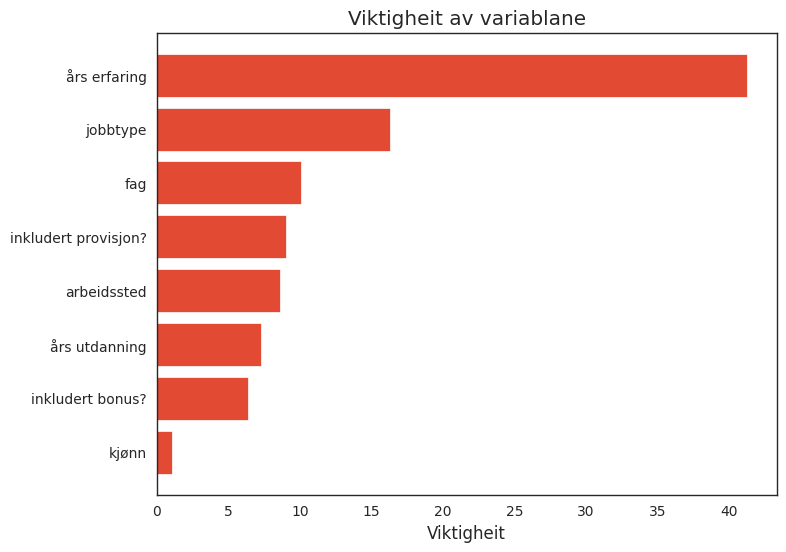

In [33]:
model = CatBoostRegressor(cat_features=cat_cols, **params)
model.fit(X, y)

feature_importance = model.get_feature_importance()
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_xlabel('Viktigheit')
ax.set_title('Viktigheit av variablane')
plt.show()